# TISSUE multiple imputation framework for differential gene expression analysis

This notebook contains code for generating figures largely corresponding to Figure 3 of the manuscript.

It generally relies on the outputs of the `get_multi_ttest.py` and `get_external_multi_ttest.py` scripts. In particular, it requires running the Python commands in the job scripts `run_dgea.slurm` and `run_external_dgea.slurm`. The h5ad anndata objects should be saved into "scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/" with respect to the current working directory (or an alternative path for stratified grouping results).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal
from statsmodels.stats.multitest import multipletests

from TISSUE.tissue.main import *
from TISSUE.tissue.downstream import *

In [2]:
# Mapping to detailed descriptors

dataset_mapper = {"Dataset3": "Mouse Hipp.\n(seqFISH)",
                  "Dataset9": "Mouse VISP\n(MERFISH)",
                  "Dataset11": "Mouse PC\n(STARmap)", 
                  "Dataset12": "Human MTG\n(ISS)",
                  "Dataset13": "Mouse VISP\n(ISS)",
                  "Dataset14": "Drosophila Embryo\n(FISH)",
                  "Dataset15": "Mouse SC (Region) \n(osmFISH)",
                  "Dataset15ClusterName": "Mouse SC (Cell type) \n(osmFISH)",
                  "Dataset17": "Mouse VISP\n(ExSeq)",
                  "Axolotl": "Axolotl Brain\n(Stereo-seq)",
                  "Dataset7": "Human U2OS\n(MERFISH)",
                  "Dataset1": "Mouse Gast.\n(seqFISH)"}

method_mapper = {"tangram": "Tangram",
                 "spage": "SpaGE",
                 "knn": "Harmony",
                 "gimvi": "gimVI"}

## Simulation studies with SRTsim

In a nutshell, the simulation setup contains two groups with identical true/measured expression as generated by SRTsim. We then add a prediction bias that artificially produces a difference in expression for some genes between the two groups and record the error rate of traditional differential gene expression analysis and of TISSUE multiple imputation different gene expression analysis on the predicted gene expressions.

In [3]:
def simulate_data_fromfile (dataset_name, mu, sigma_imputation=0.1, n_test=75):
    '''
    Creates simulated imputation bias for a given synthetic dataset between conditions
    
    "condition" must be a column in the Metadata.txt file and contain "A" and "B" only
    '''
    # read in dataset
    adata = load_spatial_data("DataUpload/"+dataset_name+"/Spatial_count.txt",
                              "DataUpload/"+dataset_name+"/Locations.txt",
                              "DataUpload/"+dataset_name+"/Metadata.txt")    
    
    # prediction simulation with added bias
    measured = np.array(adata.X.copy())
    imputed = np.empty_like(measured)
    A_idxs = list(np.where(adata.obs["condition"] == "A")[0])
    B_idxs = list(np.where(adata.obs["condition"] == "B")[0])
    bias_idxs = list(np.random.choice(np.arange(adata.shape[1]), size=round(adata.shape[1]/2), replace=False))
    nobias_idxs = [i for i in range(adata.shape[1]) if i not in bias_idxs]
    
    # for condition A, no bias
    imputed[A_idxs,:] = measured[A_idxs,:] + np.random.normal(0,sigma_imputation,
                                             (len(A_idxs),measured.shape[1]))
    
    # for condition B, bias in half of the genes
    imputed[np.ix_(B_idxs,nobias_idxs)] = measured[np.ix_(B_idxs,nobias_idxs)] + np.random.normal(0,sigma_imputation,
                                                                        (len(B_idxs),len(nobias_idxs)))
    imputed[np.ix_(B_idxs,bias_idxs)] = measured[np.ix_(B_idxs,bias_idxs)] + np.random.normal(mu,sigma_imputation,
                                                                        (len(B_idxs),len(bias_idxs)))

    # add prediction to anndata
    adata.obsm["sim_predicted_expression"] = pd.DataFrame(imputed, columns=adata.var_names, index=adata.obs_names)
    
    # get calib genes
    np.random.seed(444)
    calib_genes = np.random.choice(adata.var_names,adata.shape[1]-n_test,replace=False)
    
    # map condition keys
    condition_mapper = {"A":"0", "B":"1"}
    adata.obs['condition'] = [condition_mapper[x] for x in adata.obs['condition']]
    
    return (adata, calib_genes)

In [6]:
# Run simulation for different bias levels (mu) and record error rate

p_cutoff = 0.05
mu_offsets = np.linspace(0,0.5,30)

err_dict = {}
err_dict["measured"] = {}
err_dict["measured"]["mean"] = []
err_dict["measured"]["range"] = []
err_dict["imputed"] = {}
err_dict["imputed"]["mean"] = []
err_dict["imputed"]["range"] = []
err_dict["mi"] = {}
err_dict["mi"]["mean"] = []
err_dict["mi"]["range"] = []


for mu in mu_offsets:
    
    err_measured = []
    err_imputed = []
    err_mi = []
    
    for i in range(20):
        
        #################################
        # Simulate data + run TISSUE
        #################################
        
        #adata, calib_genes = simulate_data(mu)
        adata, calib_genes = simulate_data_fromfile("SRTsim_main_two_conditions_same", mu)
        
        # build spatial graph
        build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)

        # conformalize
        conformalize_spatial_uncertainty(adata, "sim_predicted_expression", calib_genes, weight="exp_cos", mean_normalized=False,
                                         grouping_method="kmeans_gene_cell", k='auto', k2='auto', n_pc=15)
        
        # mi testing
        multiple_imputation_testing (adata, "sim_predicted_expression", calib_genes, "condition", n_imputations=100,
                             group1="0", group2="1", symmetric=False)
        
        
        #################################
        # Get p-values and error rates
        #################################
        
        g1_bool = (adata.obs["condition"] == "0") # g1
        g2_bool = (adata.obs["condition"] != "0") # all other
        
        bonferroni_factor = adata.shape[1]-len(calib_genes)
        
        # measured values
        tt, pp = two_sample_ttest(adata.X, g1_bool, g2_bool)
        pp = pp[~adata.var_names.isin(calib_genes)]
        rejected = multipletests(pp, alpha=p_cutoff, method='fdr_bh')[0]
        err = np.nanmean(rejected)
        err_measured.append(err)

        # point estimate (from just imputed values)
        tt, pp = two_sample_ttest(adata.obsm["sim_predicted_expression"][adata.var_names].values, g1_bool, g2_bool)
        pp = pp[~adata.var_names.isin(calib_genes)]
        rejected = multipletests(pp, alpha=p_cutoff, method='fdr_bh')[0]
        err = np.nanmean(rejected)
        err_imputed.append(err)
        
        # mi values
        pp = adata.uns['sim_0_1_pvalue'][adata.var_names].values
        pp = pp[0][~adata.var_names.isin(calib_genes)]
        rejected = multipletests(pp, alpha=p_cutoff, method='fdr_bh')[0]
        err = np.nanmean(rejected)
        err_mi.append(err)
        
    # append results
    err_dict["measured"]["mean"].append(np.nanmean(err_measured))
    err_dict["imputed"]["mean"].append(np.nanmean(err_imputed))
    err_dict["mi"]["mean"].append(np.nanmean(err_mi))
    
    err_dict["measured"]["range"].append((np.nanmin(err_measured),(np.nanmax(err_measured))))
    err_dict["imputed"]["range"].append((np.nanmin(err_imputed),(np.nanmax(err_imputed))))
    err_dict["mi"]["range"].append((np.nanmin(err_mi),(np.nanmax(err_mi))))

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_inde

In [7]:
# # pickle dict (uncomment following lines)

# with open(f"results/hypothesis_testing/simulated_mu_0_05_30_default_params_20rep_SRTsim.pkl", "wb") as f:
#     pickle.dump(err_dict, f)

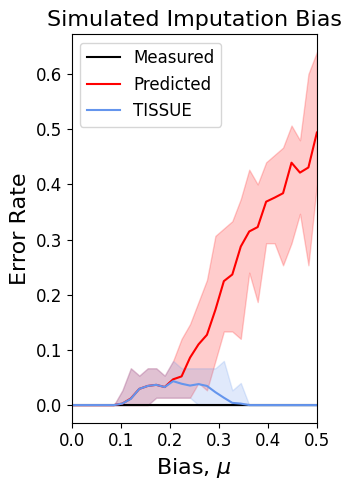

In [10]:
# Generate plot of error rate as function of the bias

filename = "simulated_mu_0_05_30_default_params_20rep_SRTsim"
mu_offsets = np.linspace(0,0.5,30)

###############

with open(f"results/hypothesis_testing/{filename}.pkl", "rb") as f:
    err_dict = pickle.load(f)

plt.figure(figsize=(3.5,5))

plt.plot(mu_offsets, err_dict["measured"]["mean"], label="Measured", color="k")
plt.plot(mu_offsets, err_dict["imputed"]["mean"], label="Predicted", color="r")
plt.plot(mu_offsets, err_dict["mi"]["mean"], label="TISSUE", color="cornflowerblue")

plt.fill_between(mu_offsets, [x[0] for x in err_dict["measured"]["range"]],
                 [x[1] for x in err_dict["measured"]["range"]], color="k", alpha=0.2)
plt.fill_between(mu_offsets, [x[0] for x in err_dict["imputed"]["range"]],
                 [x[1] for x in err_dict["imputed"]["range"]], color="r", alpha=0.2)
plt.fill_between(mu_offsets, [x[0] for x in err_dict["mi"]["range"]],
                 [x[1] for x in err_dict["mi"]["range"]], color="cornflowerblue", alpha=0.2)

plt.title("Simulated Imputation Bias", fontsize=16)
plt.xlabel(r"Bias, $\mu$", fontsize=16)
plt.ylabel("Error Rate", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(np.min(mu_offsets),np.max(mu_offsets))
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/scpi_dgea/{filename}.pdf")
plt.show()

## Generate dictionary from results from datasets

Reads individual AnnData results from `get_multi_ttest.py` and formats them into the same dictionary for aggregate analysis.

In [3]:
# Generate dictionary of results from the AnnData objects

dataset_names = ["Dataset3", "Dataset13", "Dataset14", "Dataset15ClusterName", "Dataset15", "Dataset1", "Axolotl"]
conditions = ["celltype", "celltype_lowres", "region", "ClusterName", "Region", "celltype_mapped_refined", "Annotation"]


##################
combined_stat_result_dict = {}

# loop datasets
for i in range(len(dataset_names)):
    
    # get condition and dataset name
    condition=conditions[i]
    dataset_name=dataset_names[i]
    
    # read result anndata object
    adata = sc.read_h5ad(f'scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/{dataset_name}_knn_spage_tangram_MI_TTEST.h5ad')
    
    # add key to dictionary for dataset
    combined_stat_result_dict[dataset_name] = {}
    
    # loop methods
    for method in ["spage", "tangram", "knn"]:

        # init subdict
        combined_stat_result_dict[dataset_name][method] = {}

        for g1 in np.unique(adata.obs[condition]):
            
            # define groups
            key = str(g1)+"_all"
            g1_bool = (adata.obs[condition] == g1) # g1
            g2_bool = (adata.obs[condition] != g1) # all other
            
            # add new entries to dictionary
            combined_stat_result_dict[dataset_name][method][key] = {}
            combined_stat_result_dict[dataset_name][method][key]["gene"] = adata.var_names.values

            # add TISSUE t-test results from adata.var
            var_key = method+"_"+key
            combined_stat_result_dict[dataset_name][method][key]["mi_pvalue"] = adata.var[var_key+"_pvalue"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_tstat"] = adata.var[var_key+"_tstat"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varw"] = adata.var[var_key+"_varw"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varb"] = adata.var[var_key+"_varb"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_poolmean"] = adata.var[var_key+"_poolmean"].values

            # t-test for true/measured values
            tt, pp = two_sample_ttest(adata.X, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["true_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["true_tstat"] = tt

            # t-test for predicted/imputed values
            tt, pp = two_sample_ttest(adata.obsm[method+"_predicted_expression"][adata.var_names].values, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["imp_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["imp_tstat"] = tt

# pickle dict
# with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "wb") as f:
#     pickle.dump(combined_stat_result_dict, f)

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputationTISSUE/TISSUE/tissue/downstream.py:486: RuntimeWarning: invalid value encountered in true_divide
  tt = mean_diff/pooled_sd


### For TISSUE with automated stratified grouping

Same code except for the automated stratified grouping from results in the directory: "2023Aug1_kautokauto_SDbasedCCPplus1"

In [4]:
# Generate dictionary of results from the AnnData objects

dataset_names = ["Dataset3", "Dataset13", "Dataset14", "Dataset15ClusterName", "Dataset15", "Dataset1", "Axolotl"]
conditions = ["celltype", "celltype_lowres", "region", "ClusterName", "Region", "celltype_mapped_refined", "Annotation"]


##################
combined_stat_result_dict = {}

# loop datasets
for i in range(len(dataset_names)):
    
    # get condition and dataset name
    condition=conditions[i]
    dataset_name=dataset_names[i]
    
    # read result anndata object
    adata = sc.read_h5ad(f'scg_results/scpi/2023Aug1_kautokauto_SDbasedCCPplus1/{dataset_name}_knn_spage_tangram_MI_TTEST.h5ad')
    
    # add key to dictionary for dataset
    combined_stat_result_dict[dataset_name] = {}
    
    # loop methods
    for method in ["spage", "tangram", "knn"]:

        # init subdict
        combined_stat_result_dict[dataset_name][method] = {}

        for g1 in np.unique(adata.obs[condition]):
            
            # define groups
            key = str(g1)+"_all"
            g1_bool = (adata.obs[condition] == g1) # g1
            g2_bool = (adata.obs[condition] != g1) # all other
            
            # add new entries to dictionary
            combined_stat_result_dict[dataset_name][method][key] = {}
            combined_stat_result_dict[dataset_name][method][key]["gene"] = adata.var_names.values

            # add TISSUE t-test results from adata.var
            var_key = method+"_"+key
            combined_stat_result_dict[dataset_name][method][key]["mi_pvalue"] = adata.var[var_key+"_pvalue"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_tstat"] = adata.var[var_key+"_tstat"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varw"] = adata.var[var_key+"_varw"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varb"] = adata.var[var_key+"_varb"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_poolmean"] = adata.var[var_key+"_poolmean"].values

            # t-test for true/measured values
            tt, pp = two_sample_ttest(adata.X, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["true_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["true_tstat"] = tt

            # t-test for predicted/imputed values
            tt, pp = two_sample_ttest(adata.obsm[method+"_predicted_expression"][adata.var_names].values, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["imp_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["imp_tstat"] = tt

# pickle dict
# with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_kautokauto.pkl", "wb") as f:
#     pickle.dump(combined_stat_result_dict, f)

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputationTISSUE/TISSUE/tissue/downstream.py:486: RuntimeWarning: invalid value encountered in true_divide
  tt = mean_diff/pooled_sd


## Make plots of FDR as function of the p-value cutoff

Using the dictionary obtained from the previous code sections, makes plots of the false discovery rate as a function of the p-value cutoff

/tmp/ipykernel_926/826034923.py:59: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_926/826034923.py:60: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
/tmp/ipykernel_926/826034923.py:63: RuntimeWarning: divide by zero encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Predicted")
/tmp/ipykernel_926/826034923.py:63: RuntimeWarning: invalid value encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Predicted")
/tmp/ipykernel_926/826034923.py:64: RuntimeWarning: divide by zero encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_2, color='cornflowerblue', label="TISSUE")
/tmp/ipykernel_926/826034923.py:64: RuntimeWarning: invalid valu

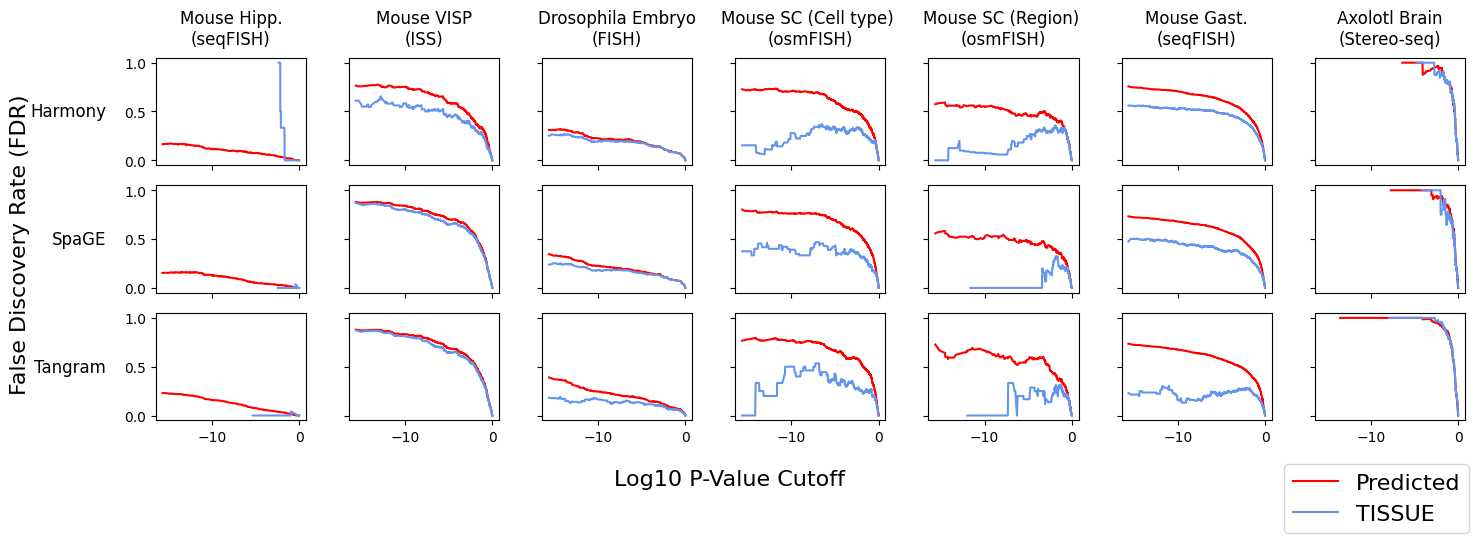

In [3]:
dataset_names = ["Dataset3", "Dataset13", "Dataset14", "Dataset15ClusterName", "Dataset15", "Dataset1", "Axolotl"]
methods = ["knn", "spage", "tangram"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n2 = len(list(combined_stat_result_dict.keys()))
n1 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(15,5), sharex=True, sharey=True)
    
# loop dataset and method to make a panel for each combo
for j, dataset in enumerate(dataset_names):
            
    for i, method in enumerate(methods):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        # FDR for predicted (baseline) and TISSUE MI
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in p_cutoff_uncorrected_arr:
            
            # get positive hits
            true_labels = (agg_x < p_cutoff_uncorrected)
            imp_labels = (agg_y1 < p_cutoff_uncorrected)
            mi_labels = (agg_y2 < p_cutoff_uncorrected)

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])
            
            # compute FDR statistic
            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
        
        # generate plot panel
        axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Predicted")
        axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_2, color='cornflowerblue', label="TISSUE")

# legend
fig.legend(["Predicted", "TISSUE"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Log10 P-Value Cutoff", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
cols = [dataset_mapper[d] for d in list(dataset_names)]
rows = [method_mapper[m] for m in list(methods)]
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/REVISED_paneled_pvalue_dosage_fdr_curves.pdf", bbox_inches='tight')
plt.show()

### For TISSUE with automatic stratified grouping

/tmp/ipykernel_23790/2140838359.py:62: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_23790/2140838359.py:63: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
/tmp/ipykernel_23790/2140838359.py:66: RuntimeWarning: divide by zero encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Predicted")
/tmp/ipykernel_23790/2140838359.py:66: RuntimeWarning: invalid value encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Predicted")
/tmp/ipykernel_23790/2140838359.py:67: RuntimeWarning: divide by zero encountered in log10
  axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_2, color='cornflowerblue', label="TISSUE")
/tmp/ipykernel_23790/2140838359.py:67: RuntimeWar

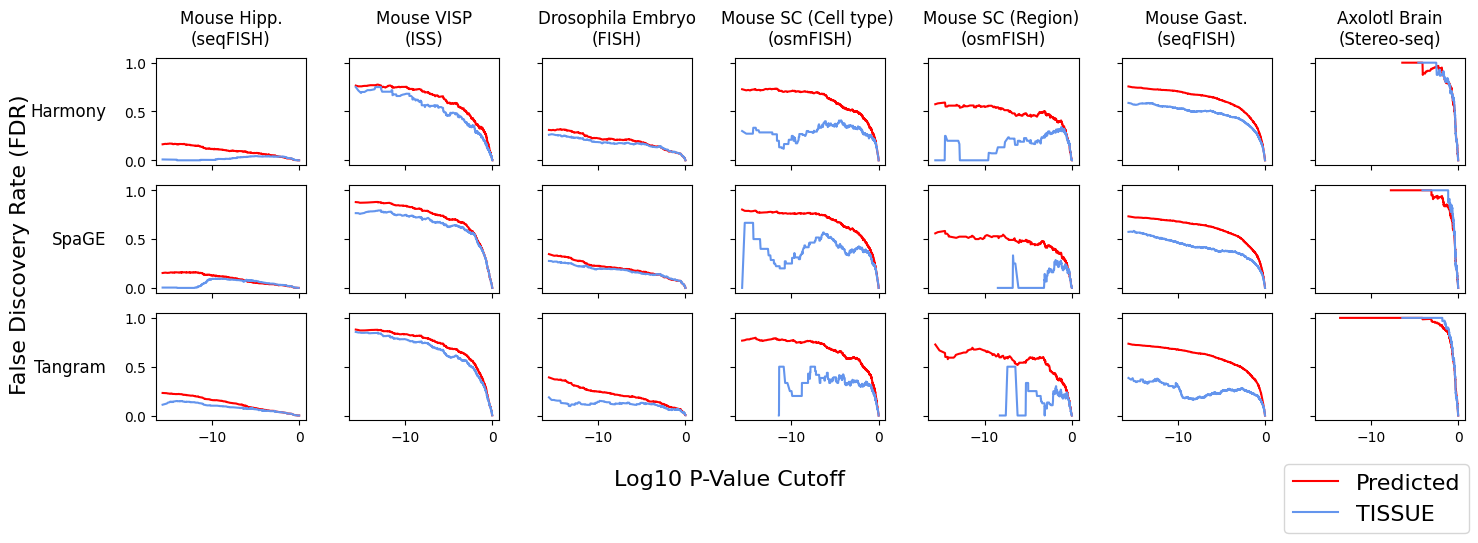

In [6]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset3", "Dataset13", "Dataset14", "Dataset15ClusterName", "Dataset15", "Dataset1", "Axolotl"]
methods = ["knn", "spage", "tangram"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_kautokauto.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n2 = len(list(combined_stat_result_dict.keys()))
n1 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(15,5), sharex=True, sharey=True)
    
    
# loop dataset and method to make a panel for each combo    
for j, dataset in enumerate(dataset_names):
            
    for i, method in enumerate(methods):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        # FDR for predicted (baseline) and TISSUE MI
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in p_cutoff_uncorrected_arr:
            
            # get positive hits
            true_labels = (agg_x < p_cutoff_uncorrected)
            imp_labels = (agg_y1 < p_cutoff_uncorrected)
            mi_labels = (agg_y2 < p_cutoff_uncorrected)

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])
            
            # compute FDR statistic
            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
        
        # generate plot panel
        axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_1, color='r', label="Predicted")
        axs[i, j].plot(np.log10(p_cutoff_uncorrected_arr), fdr_list_2, color='cornflowerblue', label="TISSUE")

# legend
fig.legend(["Predicted", "TISSUE"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Log10 P-Value Cutoff", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
cols = [dataset_mapper[d] for d in list(dataset_names)]
rows = [method_mapper[m] for m in list(methods)]
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/REVISED_paneled_pvalue_dosage_fdr_curves_kautokauto.pdf", bbox_inches='tight')
plt.show()

## Plotting FDR as function of number positives

A more natural representation is to plot FDR as a function of the total number of discoveries made.

**NOTE: The cutoff p-value for machine error is 1e-324 (this is why some of the lines cut off earlier) --> p_cutoff_uncorrected_arr<1e-324**

/tmp/ipykernel_23790/911196814.py:66: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_23790/911196814.py:67: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))


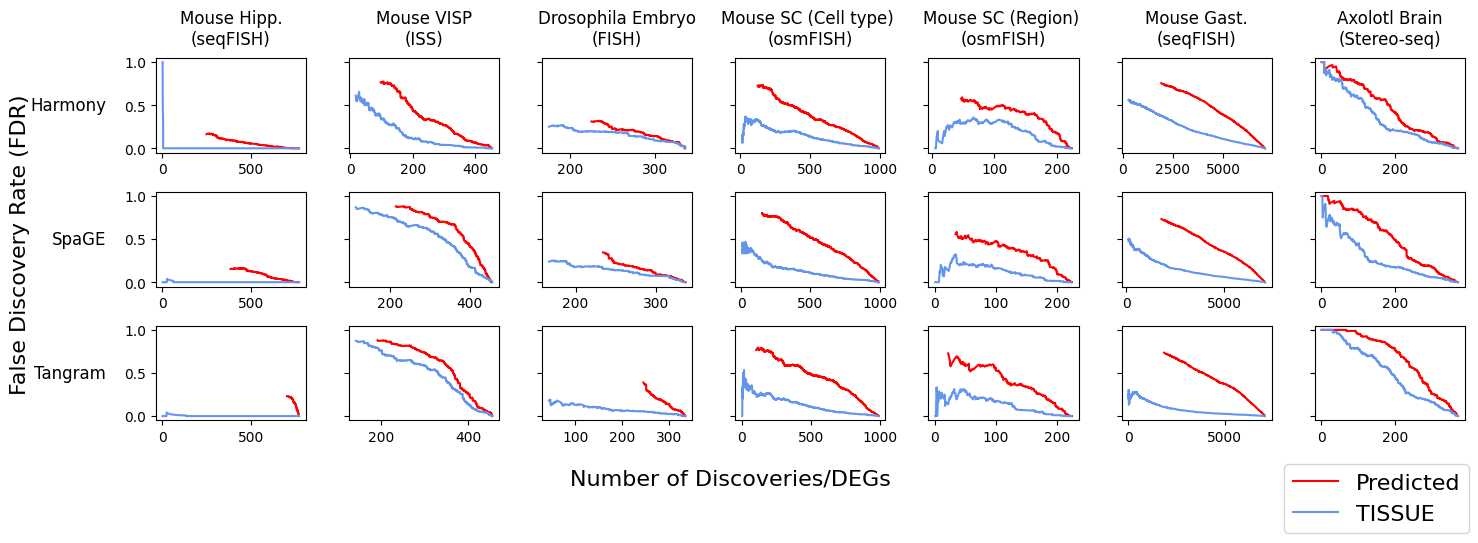

In [7]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset3", "Dataset13", "Dataset14", "Dataset15ClusterName", "Dataset15", "Dataset1", "Axolotl"]
methods = ["knn", "spage", "tangram"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n2 = len(list(combined_stat_result_dict.keys()))
n1 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(15,5), sharex=False, sharey=True)
    
    
# loop dataset and method to make a panel for each combo    
for j, dataset in enumerate(dataset_names):
            
    for i, method in enumerate(methods):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        # Number of discoveries
        num_pos_1 = []
        num_pos_2 = []
        
        # FDR for predicted (baseline) and TISSUE MI
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in np.float128(p_cutoff_uncorrected_arr):
            
            # get positive hits
            true_labels = np.float128(agg_x) < p_cutoff_uncorrected
            imp_labels = np.float128(agg_y1) < p_cutoff_uncorrected
            mi_labels = np.float128(agg_y2) < p_cutoff_uncorrected

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])
            
            # compute FDR statistic
            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
            
            num_pos_1.append(np.nansum(imp_labels))
            num_pos_2.append(np.nansum(mi_labels))
        
        # generate plot panel
        axs[i, j].plot(num_pos_1, fdr_list_1, color='r', label="Predicted")
        axs[i, j].plot(num_pos_2, fdr_list_2, color='cornflowerblue', label="TISSUE")

# legend
fig.legend(["Predicted", "TISSUE"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Number of Discoveries/DEGs", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
cols = [dataset_mapper[d] for d in list(dataset_names)]
rows = [method_mapper[m] for m in list(methods)]
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/REVISED_paneled_pvalue_numpositives_fdr_curves.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# For printing out values at 40% discoveries corresponding to Supplementary Table 2

dataset_names = ["Dataset3", "Dataset13", "Dataset14", "Dataset15ClusterName", "Dataset15", "Dataset1", "Axolotl"]
methods = ["knn", "spage", "tangram"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

proportion_discoveries = 0.4

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n2 = len(list(combined_stat_result_dict.keys()))
n1 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(15,5), sharex=False, sharey=True)
    
    
# loop dataset and method to make a panel for each combo    
for j, dataset in enumerate(dataset_names):
            
    for i, method in enumerate(methods):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        # Number of discoveries
        num_pos_1 = []
        num_pos_2 = []
        
        # FDR for predicted (baseline) and TISSUE MI
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in np.float128(p_cutoff_uncorrected_arr):
            
            # get positive hits
            true_labels = np.float128(agg_x) < p_cutoff_uncorrected
            imp_labels = np.float128(agg_y1) < p_cutoff_uncorrected
            mi_labels = np.float128(agg_y2) < p_cutoff_uncorrected

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])
            
            # compute FDR statistic
            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
            
            num_pos_1.append(np.nansum(imp_labels))
            num_pos_2.append(np.nansum(mi_labels))
        
        # threshold to report FDR for
        cut_idx1 = (np.abs(np.array(num_pos_1)-round(len(agg_x)*proportion_discoveries))).argmin()
        cut_idx2 = (np.abs(np.array(num_pos_2)-round(len(agg_x)*proportion_discoveries))).argmin()
        print(dataset)
        print(method)
        print(fdr_list_2[cut_idx2])
        print(fdr_list_1[cut_idx1])
        print("")

### For TISSUE with automated stratified grouping

/tmp/ipykernel_23790/3045951883.py:66: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_23790/3045951883.py:67: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))


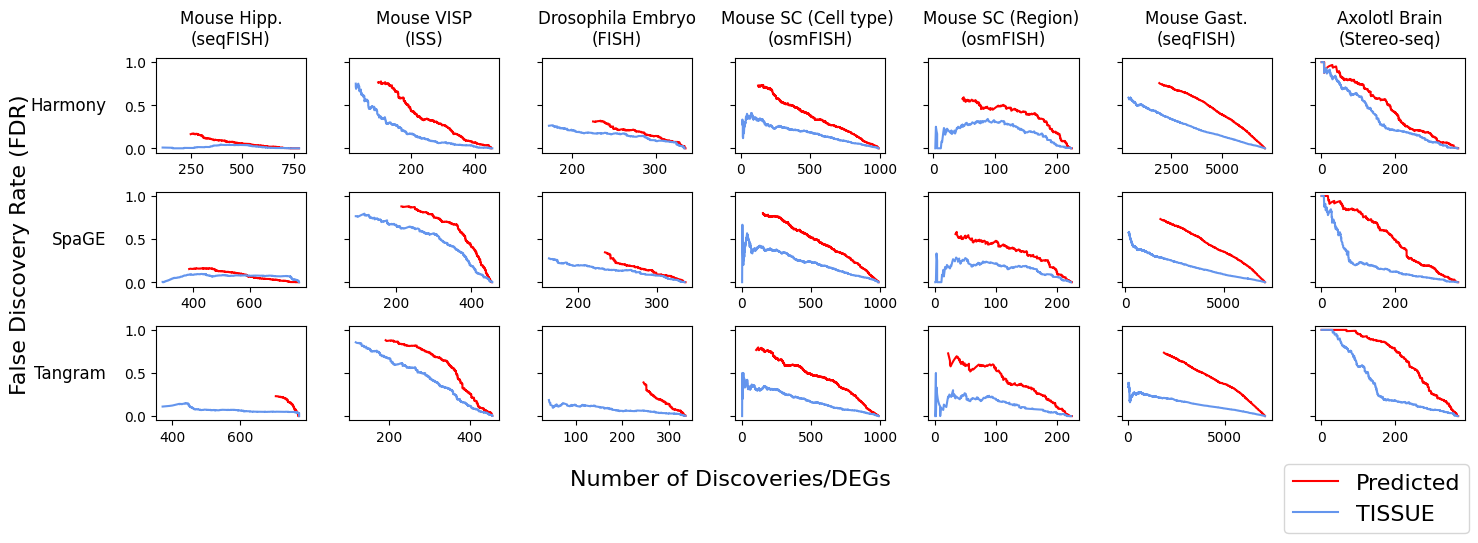

In [8]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset3", "Dataset13", "Dataset14", "Dataset15ClusterName", "Dataset15", "Dataset1", "Axolotl"]
methods = ["knn", "spage", "tangram"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_kautokauto.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n2 = len(list(combined_stat_result_dict.keys()))
n1 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(15,5), sharex=False, sharey=True)
    
    
# loop dataset and method to make a panel for each combo   
for j, dataset in enumerate(dataset_names):
            
    for i, method in enumerate(methods):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        # Number of discoveries
        num_pos_1 = []
        num_pos_2 = []
        
        # FDR for predicted (baseline) and TISSUE MI
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in np.float128(p_cutoff_uncorrected_arr):
            
            # get positive hits
            true_labels = np.float128(agg_x) < p_cutoff_uncorrected
            imp_labels = np.float128(agg_y1) < p_cutoff_uncorrected
            mi_labels = np.float128(agg_y2) < p_cutoff_uncorrected

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])
            
            # compute FDR statistic
            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
            
            num_pos_1.append(np.nansum(imp_labels))
            num_pos_2.append(np.nansum(mi_labels))
        
        # generate plot panel
        axs[i, j].plot(num_pos_1, fdr_list_1, color='r', label="Predicted")
        axs[i, j].plot(num_pos_2, fdr_list_2, color='cornflowerblue', label="TISSUE")

# legend
fig.legend(["Predicted", "TISSUE"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Number of Discoveries/DEGs", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
cols = [dataset_mapper[d] for d in list(dataset_names)]
rows = [method_mapper[m] for m in list(methods)]
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/REVISED_paneled_pvalue_numpositives_fdr_curves_kautokauto.pdf", bbox_inches='tight')
plt.show()

# CASE EXAMPLE: Annotation of granule cells in the dentate gyrus of the hippocampus using TISSUE on the mouse VISP (ISS) dataset

## Constructing gene lists for additional neuronal subclass markers to predict for the dataset

The following code generates a `subclass_genes.txt` list of genes that are used in the TISSUE multiple imputation and hypothesis testing calls using `get_external_multi_ttest.py`.

In [7]:
# read in scRNAseq data
dataset_name = "Dataset13"
with open("DataUpload/"+dataset_name+"/scRNA_count.txt","r") as f:
    lines=f.readlines()
    result=[]
    for x in lines:
        result.append(x.split('\t')[0])

gene_names = result[1:] 
gene_names = [g.lower() for g in gene_names]


with open("DataUpload/"+dataset_name+"/spatial_count.txt","r") as f:
    line=f.readline()
    result=line.split('\t')

spatial_gene_names = result[1:] 
spatial_gene_names = [g.lower() for g in spatial_gene_names]

In [8]:
# lists of gene markers from a merfish panel for neuronal subtypes
interN = ["Sst", "Vip"]
pepN = ["Hcrt","Agrp","Pomc"]
msN = ["Drd1"]
serN = ["Tph2"]

NSC = ['Prom1', 'Sox9']
Granule = ['Pdzd2', 'Gsg1l', 'Grp']
Mossy = ['Calb2', 'Tm4sf1']

# combine markers
merfish_genes = interN + pepN + msN + serN + Mossy + NSC + Granule
merfish_genes = [g.lower() for g in merfish_genes]

# remove ones already in spatial gene panel
merfish_genes = [g for g in merfish_genes if g not in spatial_gene_names]

# check for overlap with Dataset15 scRNAseq profile
overlap_genes = np.intersect1d(merfish_genes, gene_names)

# additional exclusions from filtering
add_exc_genes = ['adora2a', 'slc6a3']

overlap_genes = np.setdiff1d(overlap_genes,add_exc_genes)
print(overlap_genes)

np.savetxt("DataUpload/Dataset13/subclass_genes.txt", overlap_genes, fmt="%s")

['agrp' 'calb2' 'drd1' 'grp' 'gsg1l' 'hcrt' 'pdzd2' 'pomc' 'prom1' 'sox9'
 'sst' 'tm4sf1' 'tph2' 'vip']


## Generate dictionary for all DGEA results for external (unmeasured) genes

Uses the output of `get_external_multi_ttest.py` using the calls from `run_external_dgea.slurm` job script. Compiles a dictionary containing all differential marker expression results.

In [9]:
# Generate dictionary of results from the AnnData objects

dataset_names = ["Dataset13"]
conditions = ["celltype"]

group1 = [None]


##################
combined_stat_result_dict = {}

for i in range(len(dataset_names)):
    
    # get condition and dataset name
    condition=conditions[i]
    dataset_name=dataset_names[i]
    
    # Read AnnData object with results
    adata = sc.read_h5ad(f'scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/{dataset_name}_knn_spage_tangram_MI_EXTERNAL_TTEST.h5ad')
    
    # set up subdict
    combined_stat_result_dict[dataset_name] = {}
    
    # loop methods
    for method in ["spage", "tangram", "knn"]:

        # init subdict
        combined_stat_result_dict[dataset_name][method] = {}
        
        # set group1 to all unique values if None
        if group1[i] is None:
            group1[i] = np.unique(adata.obs[condition])
        
        # loop through each comparison group
        for g1 in group1[i]:
            
            # get groups
            key = str(g1)+"_all"
            var_key = method+"_"+key
            g1_bool = (adata.obs[condition] == g1) # g1
            g2_bool = (adata.obs[condition] != g1) # all other

            combined_stat_result_dict[dataset_name][method][key] = {}
            combined_stat_result_dict[dataset_name][method][key]["gene"] = adata.uns[var_key+"_pvalue"].columns

            # add TISSUE t-test results from uns
            combined_stat_result_dict[dataset_name][method][key]["mi_pvalue"] = adata.uns[var_key+"_pvalue"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_tstat"] = adata.uns[var_key+"_tstat"].values

            # t-test with predicted/imputed values
            tt, pp = two_sample_ttest(adata.obsm[method+"_predicted_expression"][combined_stat_result_dict[dataset_name][method][key]["gene"]].values,
                                      g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["imp_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["imp_tstat"] = tt

# pickle dict
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_external.pkl", "wb") as f:
    pickle.dump(combined_stat_result_dict, f)

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputationTISSUE/TISSUE/tissue/downstream.py:486: RuntimeWarning: invalid value encountered in true_divide
  tt = mean_diff/pooled_sd


## Neuronal (unknown) cluster identification

Visualizes the p-values from TISSUE multiple imputation (compare to baseline p-values without TISSUE) for the predicted neuronal subclass markers and identifies the cluster as granule cells.

In [6]:
# load in results from pickle file
dataset_names = ["Dataset13"]

with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_external.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

In [7]:
# find differences in DEGs of markers based on bonferroni cutoff between MI and point estimates
dataset = "Dataset13"
target_genes = np.genfromtxt("DataUpload/"+dataset+"/subclass_genes.txt", dtype=str)

# init some lists to collect results
group_col = []
method_col = []
gene_col = []
tstat_diff_col = []
tstat_mi_col = []
pval_diff_col = []
p_val_imp = []
p_val_mi = []

# loop each prediction method
for method in combined_stat_result_dict[dataset].keys():
    # loop each comparison group label
    for group1 in combined_stat_result_dict[dataset][method].keys():

        # subset genes
        genes = combined_stat_result_dict[dataset][method][group1]["gene"]
        target_bools = np.isin(genes, target_genes)

        # compute diffs
        diffs = np.abs(combined_stat_result_dict[dataset][method][group1]["mi_tstat"]-combined_stat_result_dict[dataset][method][group1]["imp_tstat"])
        pdiffs = np.abs(combined_stat_result_dict[dataset][method][group1]["mi_pvalue"]-combined_stat_result_dict[dataset][method][group1]["imp_pvalue"])
        
        # add results
        method_col.append([method]*np.sum(target_bools))
        group_col.append([group1]*np.sum(target_bools))
        gene_col.append(genes[target_bools])
        tstat_diff_col.append(diffs.flatten()[target_bools])
        tstat_mi_col.append(combined_stat_result_dict[dataset][method][group1]["mi_tstat"].flatten()[target_bools])
        pval_diff_col.append(pdiffs.flatten()[target_bools])

        p_val_imp.append(combined_stat_result_dict[dataset][method][group1]["imp_pvalue"].flatten()[target_bools])
        p_val_mi.append(combined_stat_result_dict[dataset][method][group1]["mi_pvalue"].flatten()[target_bools])

# compile dataframe of results
group_col = np.concatenate(group_col)
method_col = np.concatenate(method_col)
gene_col = np.concatenate(gene_col)
tstat_diff_col = np.concatenate(tstat_diff_col)
tstat_mi_col = np.concatenate(tstat_mi_col)
pval_diff_col = np.concatenate(pval_diff_col)
p_val_imp = np.concatenate(p_val_imp)
p_val_mi = np.concatenate(p_val_mi)

res_df = pd.DataFrame([])
res_df["group"] = group_col
res_df["gene"] = gene_col
res_df["method"] = method_col
res_df["abs_tstat_diff"] = tstat_diff_col
res_df["tstat_mi"] = tstat_mi_col
res_df["abs_pval_diff"] = pval_diff_col
res_df["p_val_imp"] = p_val_imp
res_df["p_val_mi"] = p_val_mi

In [8]:
# subset neuron clusters only
res_df = res_df[[True if ("Neuron" in x) else False for x in res_df["group"]]].reset_index()

In [11]:
# markers from before
interN = ["Sst", "Vip"]
pepN = ["Hcrt","Agrp","Pomc"]
msN = ["Drd1"]
serN = ["Tph2"]

NSC = ['Prom1', 'Sox9']
Granule = ['Pdzd2', 'Gsg1l', 'Grp']
Mossy = ['Calb2', 'Tm4sf1']

markers_list = [interN, pepN, msN, serN, Mossy, NSC, Granule]

p_cutoff = 0.05 # cutoff for significance (will be adjusted for multiple tests)

# label dictionary
neuron_dict = {"Neuron_Cdh13":"Neuron_1",
              "Neuron_Cnr1":"Neuron_2",
              "Neuron_Gad1_Inhibitory":"Neuron_3",
              "Neuron_Ndnf":"Neuron_4",
              "Neuron_R3hdm1_Interneuron":"Neuron_5",
              "Neuron_Rasl10a":"Neuron_6",
              "Neuron_Slc17a7_Excitatory":"Neuron_7",
              "Neuron_Th_Dopaminergic":"Neuron_8"}

In [12]:
# get p-values and show in table format
new_df = res_df[res_df['gene'].isin([g.lower() for g in np.concatenate(markers_list)])]
new_df = new_df[new_df['method']=="spage"]
new_df = new_df[new_df['group']=="Neuron_Rasl10a_all"]
new_df

,index,group,gene,method,abs_tstat_diff,tstat_mi,abs_pval_diff,p_val_imp,p_val_mi
205,287,Neuron_Rasl10a_all,agrp,spage,1.429990,0.105604,7.912587e-01,0.124691,9.159494e-01
206,288,Neuron_Rasl10a_all,calb2,spage,1.419820,1.275589,1.954585e-01,0.007050,2.025084e-01
211,293,Neuron_Rasl10a_all,drd1,spage,0.823529,-1.427121,1.293794e-01,0.024444,1.538232e-01
215,297,Neuron_Rasl10a_all,grp,spage,6.883997,6.291897,6.890963e-10,0.000000,6.890963e-10
216,298,Neuron_Rasl10a_all,gsg1l,spage,7.201970,6.796924,2.413825e-11,0.000000,2.413825e-11
217,299,Neuron_Rasl10a_all,hcrt,spage,8.351556,1.233530,2.180106e-01,0.000000,2.180106e-01
223,305,Neuron_Rasl10a_all,pdzd2,spage,3.763594,5.310417,1.332987e-07,0.000000,1.332987e-07
224,306,Neuron_Rasl10a_all,pomc,spage,1.806574,1.660067,9.707036e-02,0.000531,9.760106e-02
225,307,Neuron_Rasl10a_all,prom1,spage,1.615687,-1.910786,5.589669e-02,0.000424,5.632097e-02
231,313,Neuron_Rasl10a_all,sox9,spage,0.955668,-0.986770,2.717829e-01,0.052131,3.239136e-01


In [13]:
0.05/new_df.shape[0] # multiply corrected pvalue cutoff

0.0035714285714285718

### Check that granule cell markers have higher expression  --> positive means higher in group1

In [14]:
res_df[(res_df['gene'].isin([g.lower() for g in Granule]))&(res_df['group']=="Neuron_Rasl10a_all")]

,index,group,gene,method,abs_tstat_diff,tstat_mi,abs_pval_diff,p_val_imp,p_val_mi
215,297,Neuron_Rasl10a_all,grp,spage,6.883997,6.291897,6.890963e-10,0.000000,6.890963e-10
216,298,Neuron_Rasl10a_all,gsg1l,spage,7.201970,6.796924,2.413825e-11,0.000000,2.413825e-11
223,305,Neuron_Rasl10a_all,pdzd2,spage,3.763594,5.310417,1.332987e-07,0.000000,1.332987e-07
543,748,Neuron_Rasl10a_all,grp,tangram,1.067879,8.854561,0.000000e+00,0.000000,0.000000e+00
544,749,Neuron_Rasl10a_all,gsg1l,tangram,1.700049,11.552576,0.000000e+00,0.000000,0.000000e+00
551,756,Neuron_Rasl10a_all,pdzd2,tangram,3.862881,5.436280,7.433154e-08,0.000000,7.433154e-08
871,1199,Neuron_Rasl10a_all,grp,knn,1.566600,0.108589,8.196382e-01,0.093949,9.135876e-01
872,1200,Neuron_Rasl10a_all,gsg1l,knn,0.221063,-0.083731,1.727792e-01,0.760534,9.333132e-01
879,1207,Neuron_Rasl10a_all,pdzd2,knn,1.294963,-1.732805,8.095377e-02,0.002474,8.342792e-02


## Make plot of granule cell cluster on spatial coordinates

In [ ]:
# read in results anndata
adata = sc.read_h5ad(f'scg_results/scpi/Dataset13_knn_spage_tangram_MI_EXTERNAL_TTEST.h5ad')

In [10]:
# subset and orient spatial coordinates
adata = adata[adata.obs["celltype_lowres"]=="Neuron"]
adata.obsm["spatial"][:,1] = -adata.obsm["spatial"][:,1]

/tmp/ipykernel_200/1167846429.py:2: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.
  adata.obsm["spatial"][:,1] = -adata.obsm["spatial"][:,1]


In [11]:
# initial labels
neuron_dict = {"Neuron_Cdh13":"Neuron_1",
              "Neuron_Cnr1":"Neuron_2",
              "Neuron_Gad1_Inhibitory":"Neuron_3",
              "Neuron_Ndnf":"Neuron_4",
              "Neuron_R3hdm1_Interneuron":"Neuron_5",
              "Neuron_Rasl10a":"Neuron_6",
              "Neuron_Slc17a7_Excitatory":"Neuron_7",
              "Neuron_Th_Dopaminergic":"Neuron_8"}

# swap to new labels
adata.obs['celltype'] = adata.obs['celltype'].replace(neuron_dict)

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


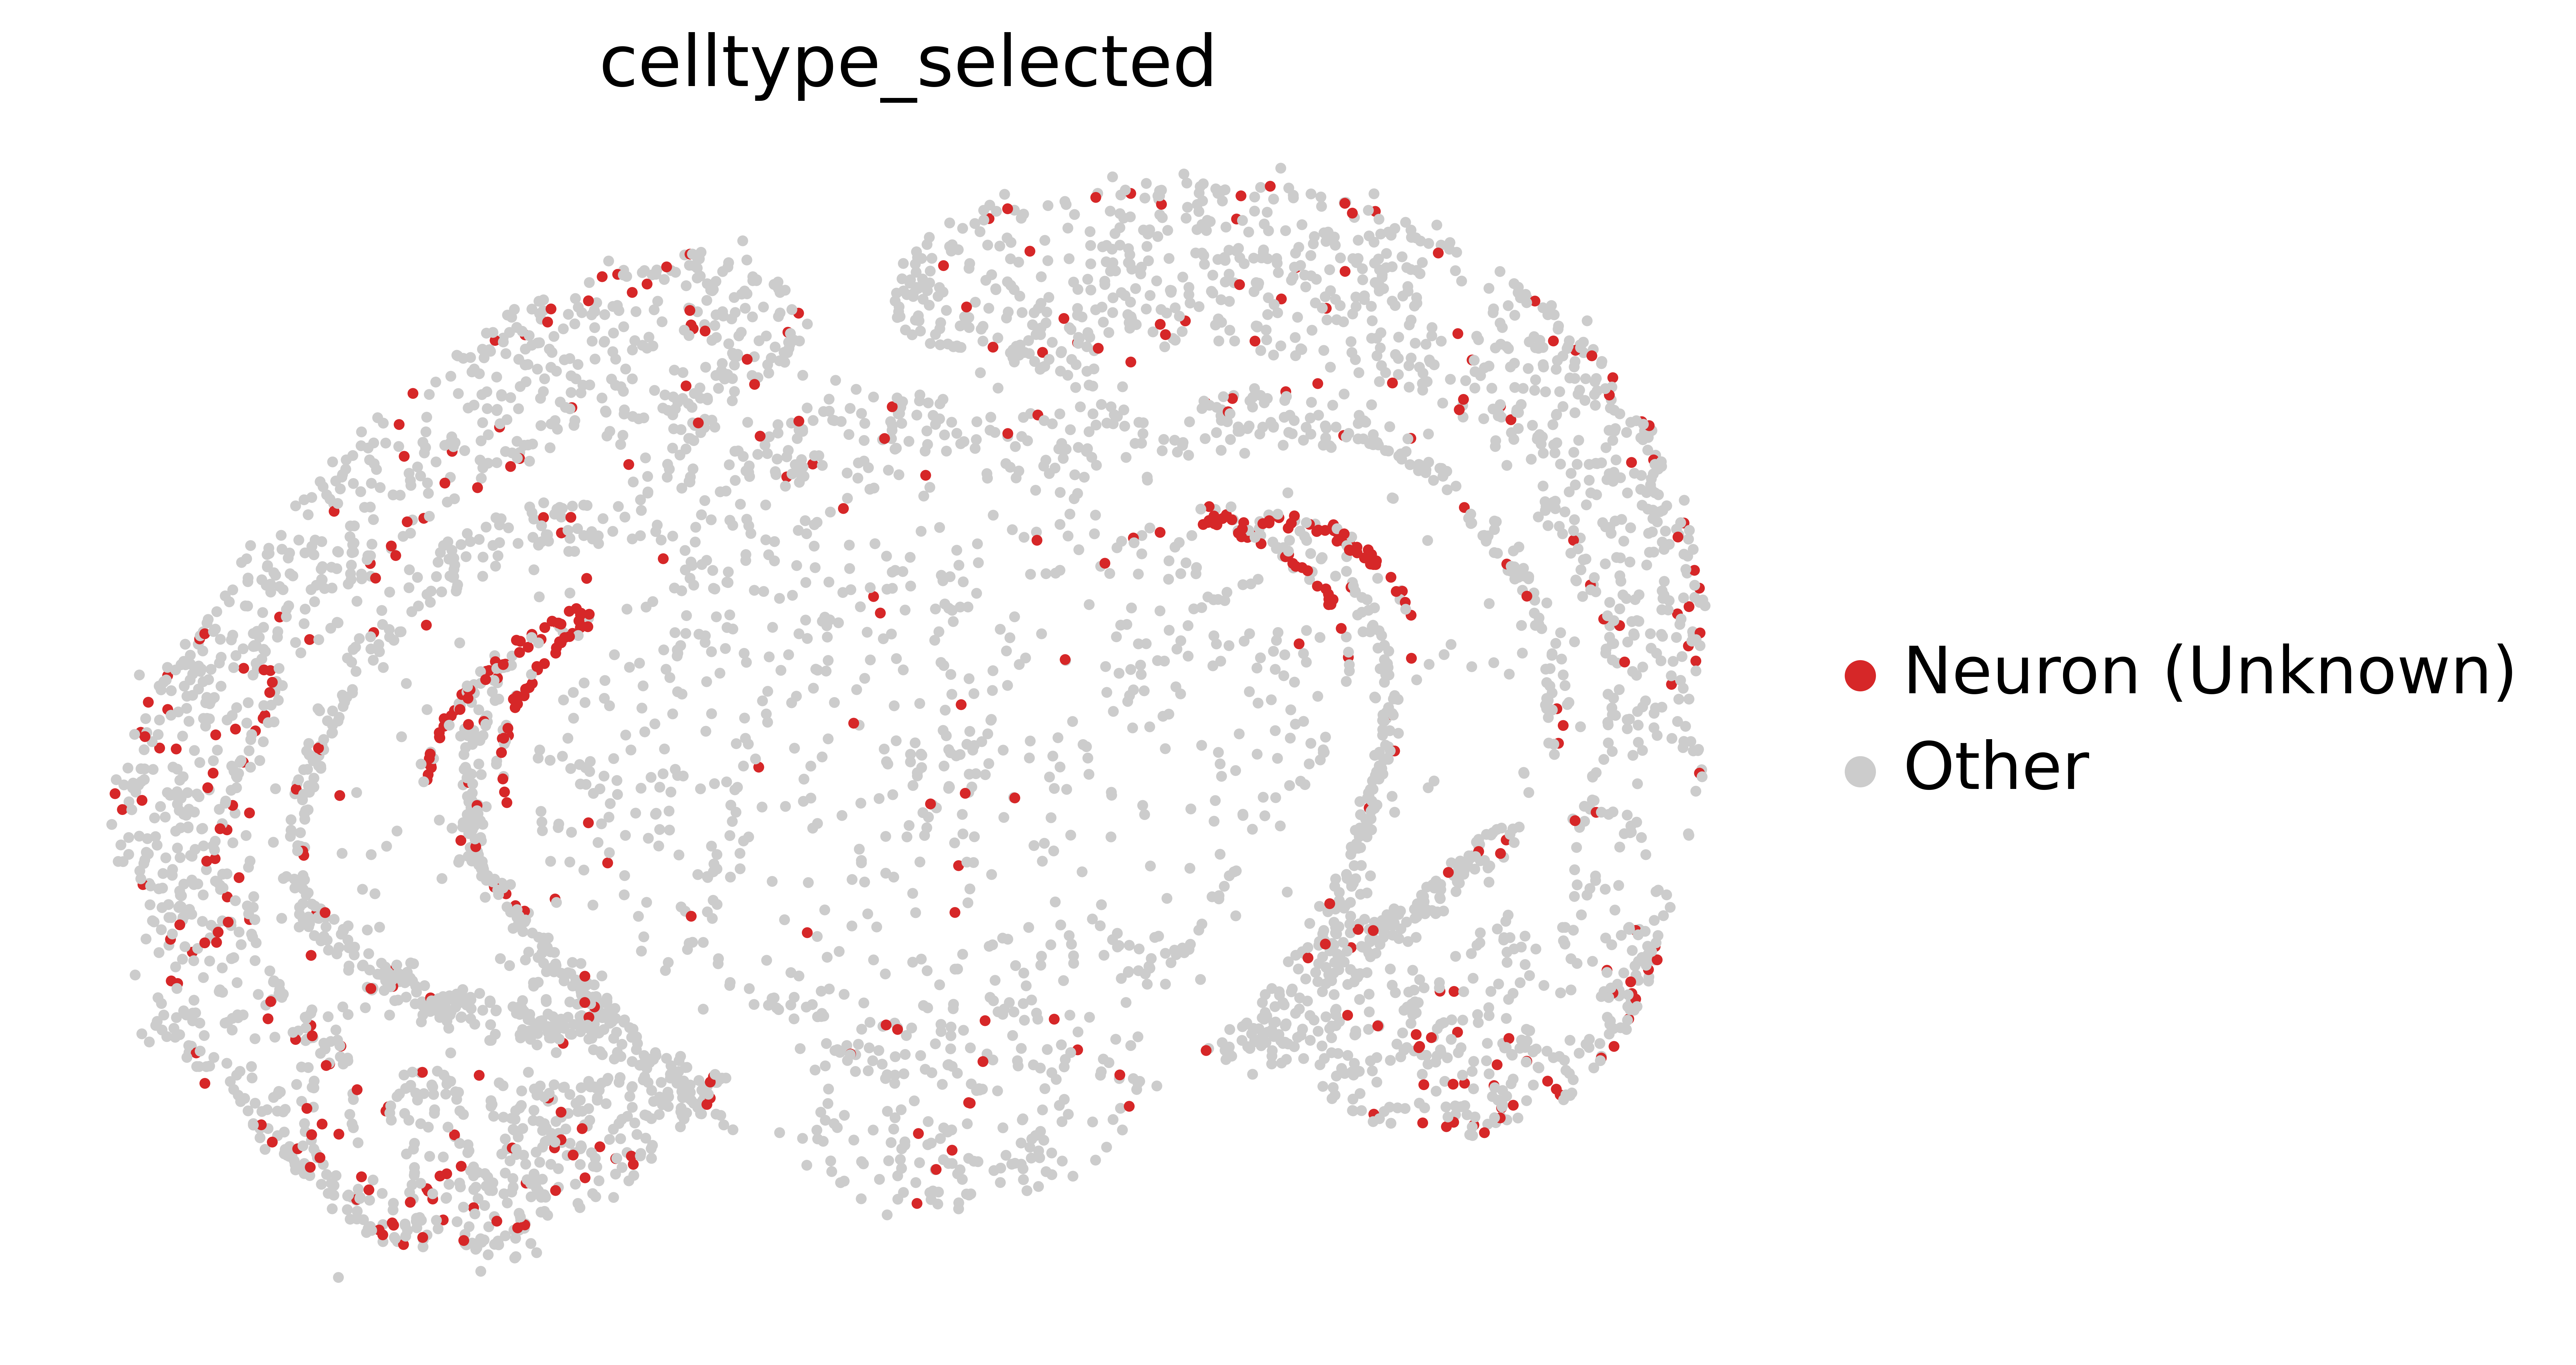

In [12]:
# Recolor and make figure
color_dict = {"Neuron (Unknown)":"tab:red",
              "Other":"0.8"}
sc.set_figure_params(vector_friendly=True)
adata.obs["celltype_selected"] = ["Neuron (Unknown)" if x=="Neuron_6" else "Other" for x in adata.obs["celltype"]]
sc.set_figure_params(vector_friendly=True, dpi=500, figsize=(7,5), fontsize=16)
sc.pl.embedding(adata, "spatial", color="celltype_selected", show=False, palette=color_dict, sort_order=False)
plt.axis('off')
plt.savefig("plots/scpi_dgea/dataset13_clusters_prox1_hippoDG_grayed_granule_only.pdf", bbox_inches="tight", dpi=500)